Import the required libraries and some set up

In [413]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import timedelta
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM

np.random.seed(1010)
PYTHONHASHSEED = 0

model_path = './finfanOUT/bin_model.h5'

Read in the data and convert the columns to datetime

In [414]:
train_df1 = pd.read_csv('./finfanIN/Data_Extract_Train.txt', sep="\t", header=None, low_memory=False)
train_df2 = pd.read_csv('./finfanIn/Data_Extract_Train2.txt', sep='\t', header=None, low_memory=False)
train_dfs = [train_df1, train_df2]


Clean the data by removing all missing values and NaNs

Merge the two by datetimes and make it the index

Fill in the missing gaps in time due to the Merge

*This should be done by interpolating speed and padding status*


*Need to remove data after the failure shouldnt be included, currently just removed from the file*

In [415]:
# given a dataframe that has 4 columns, time, speed, time, status
# merges the times and fills in the values that are missing in between
# returns the transformed dataframe
def convertData(df, index):
    df[0] = pd.to_datetime(df[0], infer_datetime_format=True)
    df[2] = pd.to_datetime(df[2], infer_datetime_format=True)
    df.columns = ['time', 'speed', 'timea', 'status']
    df1 = df.drop(columns = ['timea', 'status'])
    df2 = df.drop(columns = ['time', 'speed'])
    df2.columns = ['time', 'status']
    df1 = df1.apply(pd.to_numeric, errors='coerce')
    df1 = df1.dropna()
    df2 = df2.apply(pd.to_numeric, errors='coerce')
    df2 = df2.dropna()
    df3 = df1.merge(df2, how='outer', on='time')
    df3['time'] = pd.to_datetime(df3['time'], infer_datetime_format=True)
    df3['id'] = index
    df3 = df3.pad()
    df3 = df3.bfill()
    print(df3)
    return df3

# calculates the remaining useful life/time until failure for the training data
# by subtracting the time by the last time value
# adds a window of given size to determine as a range where the fan has started to fail
# adds both of these calculations as new columns in the dataframe and returns it
def calcRul(df, window):
    df['RUL'] = df['time'] - df.tail(1)['time'].values[0]
    df['label1'] = np.where(df['RUL'] <= window, 1, 0)
    return df

# using the scaler given (MinMaxScaler recommended) applies it to the relevant columns that require normalising
# returns the normalised dataframe
def normalise(df, scaler):
    df1 = df.apply(pd.to_numeric)
    df1['time_norm'] = df1['time']
    cols_normalise = df1.columns.difference(['time', 'RUL', 'label1', 'id'])
    norm_df = pd.DataFrame(scaler.fit_transform(df1[cols_normalise]), columns=cols_normalise, index=df1.index)
    join_df = df1[df1.columns.difference(cols_normalise)].join(norm_df)
    df2 = join_df.reindex(columns=df1.columns)
    print(df2)
    return df2


In [416]:
w1 = pd.Timedelta(days=-30)
minmax_scaler = preprocessing.MinMaxScaler()
train = None
for i, t in enumerate(train_dfs):
    if train is None:
        train = normalise(calcRul(convertData(t, i), w1), minmax_scaler)
    else:
        train = pd.concat([train, normalise(calcRul(convertData(t, i), w1), minmax_scaler)], copy=False)
print(train)

                      time   speed  status  id
0      2019-01-01 00:00:09  2644.0     0.0   0
1      2019-01-01 00:00:19  2645.0     0.0   0
2      2019-01-01 00:01:09  2645.0     0.0   0
3      2019-01-01 00:01:19  2644.0     0.0   0
4      2019-01-01 00:01:29  2645.0     0.0   0
...                    ...     ...     ...  ..
366009 2019-08-13 13:50:11    -5.0     0.0   0
366010 2019-08-13 21:47:17    -5.0     0.0   0
366011 2019-08-14 05:47:11    -5.0     0.0   0
366012 2019-08-14 13:42:10    -5.0     0.0   0
366013 2019-08-14 18:42:50    -5.0     1.0   0

[366014 rows x 4 columns]
                       time     speed  status  id                RUL  label1  \
0       1546300809000000000  0.996615     0.0   0 -19507361000000000       1   
1       1546300819000000000  0.996991     0.0   0 -19507351000000000       1   
2       1546300869000000000  0.996991     0.0   0 -19507301000000000       1   
3       1546300879000000000  0.996615     0.0   0 -19507291000000000       1   
4       1

Start of LSTM section 

In [417]:
# pick large window
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]


Pick the feature columns

In [418]:
sensor_cols = ['speed']
# operater controlled things
sequence_cols = ['status', 'time_norm']
sequence_cols.extend(sensor_cols)
# eventually make this loop to list for each different training fan id/datasource
seq_gen = (list(gen_sequence(train[train['id'] == id], sequence_length, sequence_cols)) for id in train['id'].unique())

seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(655534, 50, 3)


In [419]:
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]
# eventually make this loop to list for each different training fan
label_gen = [gen_labels(train[train['id'] == id], sequence_length, ['label1'])
for id in train['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(655534, 1)

Build a deep network

In [420]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
    input_shape=(sequence_length, nb_features),
    units=100,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 50, 100)           41600     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_23 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 71,851
Trainable params: 71,851
Non-trainable params: 0
_________________________________________________________________
None


In [427]:
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.2, verbose=2, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'), keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
                    )
print(history.history.keys())

Epoch 1/10
2623/2623 - 53s - loss: 0.0507 - accuracy: 0.9809 - val_loss: 0.8122 - val_accuracy: 0.3779
Epoch 2/10
2623/2623 - 53s - loss: 0.0319 - accuracy: 0.9881 - val_loss: 0.1276 - val_accuracy: 0.9158
Epoch 3/10
2623/2623 - 53s - loss: 0.0242 - accuracy: 0.9903 - val_loss: 0.0192 - val_accuracy: 0.9940
Epoch 4/10
2623/2623 - 52s - loss: 0.0206 - accuracy: 0.9925 - val_loss: 0.0316 - val_accuracy: 0.9940
Epoch 5/10
2623/2623 - 54s - loss: 0.0164 - accuracy: 0.9934 - val_loss: 0.0226 - val_accuracy: 0.9941
Epoch 6/10
2623/2623 - 52s - loss: 0.0156 - accuracy: 0.9937 - val_loss: 0.0226 - val_accuracy: 0.9941
Epoch 7/10
2623/2623 - 54s - loss: 0.0147 - accuracy: 0.9941 - val_loss: 0.0246 - val_accuracy: 0.9942
Epoch 8/10
2623/2623 - 55s - loss: 0.0147 - accuracy: 0.9943 - val_loss: 0.0187 - val_accuracy: 0.9942
Epoch 9/10
2623/2623 - 51s - loss: 0.0119 - accuracy: 0.9952 - val_loss: 0.0284 - val_accuracy: 0.9942
Epoch 10/10
2623/2623 - 53s - loss: 0.0127 - accuracy: 0.9949 - val_loss:

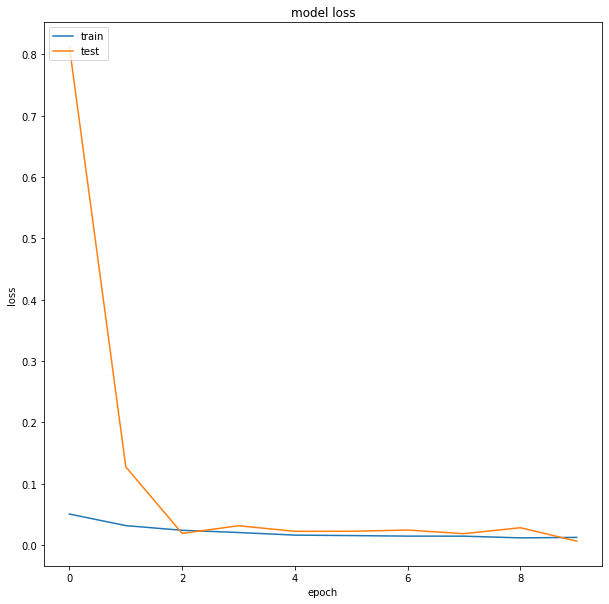

In [428]:
fig_acc = plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [429]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

3278/3278 [==============================] - 27s 8ms/step - loss: 0.0213 - accuracy: 0.9901
Accurracy: 0.9900737404823303


In [430]:
y_pred = model.predict_classes(seq_array, verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

3278/3278 [==============================] - 27s 8ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[238688     14]
 [  6493 410339]]


In [431]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print('precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9999658830324135 
 recall =  0.9844229809611547
